### Feature Matching
We will see how to match features in one image with others.

We will use the Brute-Force matcher and FLANN Matcher in OpenCV

Here, we will see a simple example on how to match features between two images. In this case, I have a queryImage and a trainImage. We will try to find the queryImage in trainImage using feature matching.

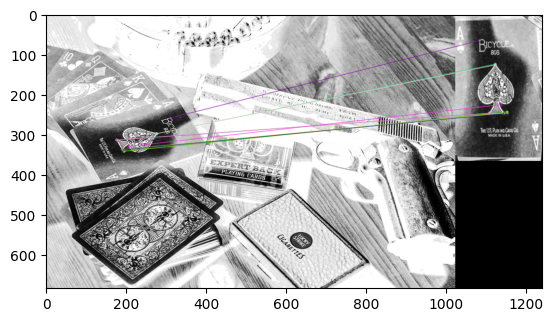

(<matplotlib.image.AxesImage at 0x249c3da0bc0>, None)

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('table.png', cv.IMREAD_GRAYSCALE)          # queryImage
img1 = cv.bitwise_not(img1)
img2 = cv.imread('card.png', cv.IMREAD_GRAYSCALE) # trainImage
img2 = cv.bitwise_not(img2)
# Initiate ORB detector
orb = cv.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### Brute-Force Matching with SIFT Descriptors and Ratio Test
This time, we will use BFMatcher.knnMatch() to get k best matches. In this example, we will take k=2 so that we can apply ratio test explained by D.Lowe in his paper.

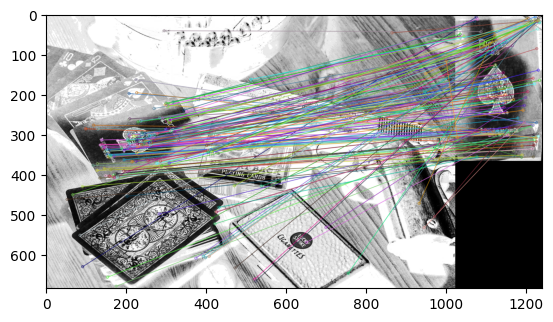

(<matplotlib.image.AxesImage at 0x249c4f69760>, None)

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('table.png', cv.IMREAD_GRAYSCALE)          # queryImage
img1 = cv.bitwise_not(img1)
img2 = cv.imread('card.png', cv.IMREAD_GRAYSCALE) # trainImage
img2 = cv.bitwise_not(img2)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

### FLANN based Matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors.

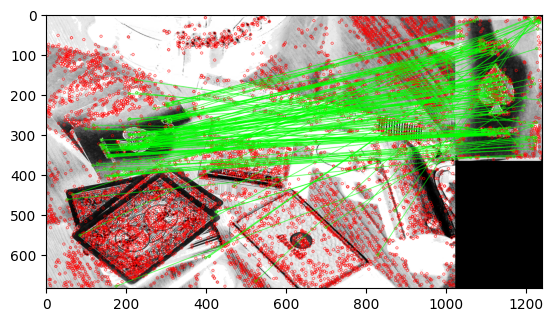

(<matplotlib.image.AxesImage at 0x249d92fd220>, None)

In [5]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = cv.imread('table.png', cv.IMREAD_GRAYSCALE)          # queryImage
img1 = cv.bitwise_not(img1)
img2 = cv.imread('card.png', cv.IMREAD_GRAYSCALE) # trainImage
img2 = cv.bitwise_not(img2)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

### Feature Matching + Homography to find Objects
First, as usual, let's find SIFT features in images and apply the ratio test to find the best matches.

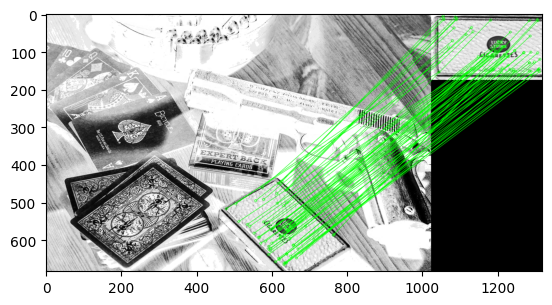

(<matplotlib.image.AxesImage at 0x249d9098290>, None)

In [7]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
img1 = cv.imread('table.png', cv.IMREAD_GRAYSCALE)          # queryImage
img1 = cv.bitwise_not(img1)
# img2 = cv.imread('card.png',cv.IMREAD_GRAYSCALE) # trainImage
img2 = cv.imread('pic3.png', cv.IMREAD_GRAYSCALE) # trainImage
img2 = cv.bitwise_not(img2)
# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()